In [1]:
# Set environment variable to avoid symbolic tracing issues
import os
os.environ['TIMM_FUSED_ATTN'] = '0'
from torchvision import transforms
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

# Import XAI methods
from baselines.CRP_LXT import CRP_LXT

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from PIL import Image, ImageDraw
from pathlib import Path

/blue/guoj1/tienyuchang/.conda/envs/octxai/lib/python3.9/site-packages/lxt/efficient/zennit_patches.py:22: UserWarning: 'zennit' library is not available. Please install it to use for vision transformers.
  warn("'zennit' library is not available. Please install it to use for vision transformers.")


In [2]:
from transformers import (
    ViTImageProcessor, ViTForImageClassification,
    AutoImageProcessor, EfficientNetForImageClassification,
    ResNetForImageClassification, AutoModel
)
import models_vit as models
from util.datasets import TransformWrapper
import timm

#get model
def get_model(task,model,input_size,nb_classes):
    if 'ADCon' in task:
        id2label = {0: "control", 1: "ad"}
        label2id = {v: k for k, v in id2label.items()}
    else:
        id2label = {i: f"class_{i}" for i in range(nb_classes)}
        label2id = {v: k for k, v in id2label.items()}
    processor = None
    if 'RETFound_mae' in model:
        model = models.__dict__['RETFound_mae'](
        img_size=input_size,
        num_classes=nb_classes,
        drop_path_rate=0.2,
        global_pool=True,
    )
    elif 'vit-base-patch16-224' in model:
        # ViT-base-patch16-224 preprocessor
        model_ = 'google/vit-base-patch16-224'
        processor = TransformWrapper(ViTImageProcessor.from_pretrained(model_))
        model = ViTForImageClassification.from_pretrained(
            model_,
            image_size=input_size, #Not in tianhao code, default 224
            num_labels=nb_classes,
            hidden_dropout_prob=0.0, #Not in tianhao code, default 0.0
            attention_probs_dropout_prob=0.0, #Not in tianhao code, default 0.0
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True,
            attn_implementation="eager",      # ← key line
        )
        model.config.return_dict = True
        model.config.output_attentions = True
    elif 'timm_efficientnet-b4' in model:
        model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=nb_classes)
        processor  = transforms.Compose([
            transforms.Resize((380,380)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
    elif 'ResNet-50' in model:
        model_name = 'microsoft/resnet-50'
        processor = TransformWrapper(AutoImageProcessor.from_pretrained(model_name))
        model = ResNetForImageClassification.from_pretrained(
            model_name,
            num_labels=nb_classes,
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )
        model.config.return_dict = True
        model.config.output_attentions = True

    return model, processor

# Data Load

In [3]:
# task and dataset
#Task_list = ['ADCon','DME']
LOAD_MASK = True
IMG_MASK = True
HEATMAP_MASK = False
DRAW_LAYER = True
Thickness_DIR = "/orange/ruogu.fang/tienyuchang/IRB2024_OCT_thickness/Data/"
Thickness_CSV = "/orange/ruogu.fang/tienyuchang/IRB2024_OCT_thickness/thickness_map.csv"
Task_list = ['DME']
dataset_fname = 'sampled_labels01.csv'
dataset_dir = '/blue/ruogu.fang/tienyuchang/OCT_EDA'
img_p_fmt = "label_%d/%s" #label index and oct_img name

# model
Model_root = "/blue/ruogu.fang/tienyuchang/RETFound_MAE/output_dir"
Model_fname = "checkpoint-best.pth"
Model_list = ['ResNet-50', 'timm_efficientnet-b4', 'vit-base-patch16-224', 'RETFound_mae']
ADCon_finetuned = [
    "ad_control_detect_data-IRB2024v5_ADCON_DL_data-all-resnet-50-OCT-defaulteval---bal_sampler-/",
    "ad_control_detect_data-IRB2024v5_ADCON_DL_data-all-timm_efficientnet-b4-OCT-defaulteval---bal_sampler-/",
    "ad_control_detect_data-IRB2024v5_ADCON_DL_data-all-vit-base-patch16-224-OCT-defaulteval---bal_sampler-/",
    "ad_control_detect_data-IRB2024v5_ADCON_DL_data-all-RETFound_mae-OCT-defaulteval---bal_sampler-/"
]
DME_finetuned = [
    "DME_binary_all_split-IRB2024_v5-all-microsoft/resnet-50-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0--/",
    "DME_binary_all_split-IRB2024_v5-all-timm_efficientnet-b4-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0--/",
    "DME_binary_all_split-IRB2024_v5-all-google/vit-base-patch16-224-in21k-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0--/",
    "DME_binary_all_split-IRB2024_v5-all-RETFound_mae_natureOCT-OCT-bs16ep50lr5e-4optadamw-roc_auceval-trsub0--/"
]

Model_root = "/orange/ruogu.fang/tienyuchang/RETfound_results"
DME_finetuned_masked = [
    "DME_binary_all_split-IRB2024_v5-all-microsoft/resnet-50-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/",
    "DME_binary_all_split-IRB2024_v5-all-timm_efficientnet-b4-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/",
    "DME_binary_all_split-IRB2024_v5-all-google/vit-base-patch16-224-in21k-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/",
    "DME_binary_all_split-IRB2024_v5-all-RETFound_mae_natureOCT-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/"
]


After adding mask, data len:  199
199
<PIL.Image.Image image mode=RGB size=512x496 at 0x14C81A4E5670>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


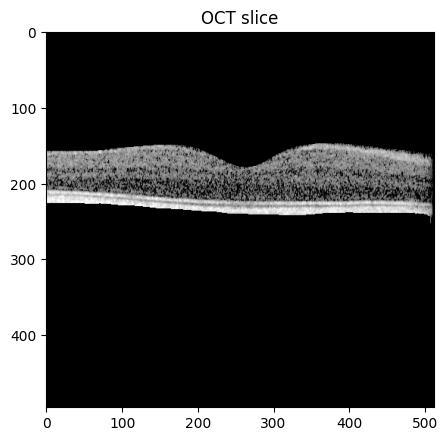

[[158 158 158 ... 163 161 161]
 [164 164 164 ... 180 180 180]
 [167 167 167 ... 188 189 189]
 ...
 [216 216 216 ... 230 223 225]
 [220 220 220 ... 238 230 231]
 [227 227 227 ... 243 236 237]]
(496, 512, 3)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


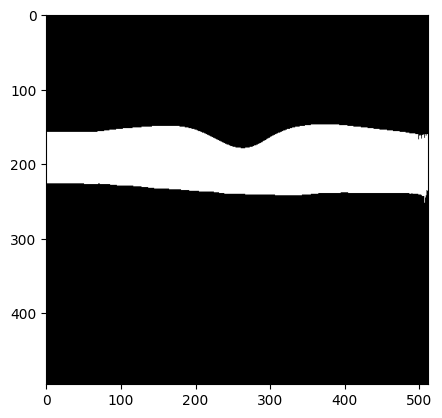

In [4]:
def _build_binary_mask(mask_slice, heatmap):
    binary_mask = np.zeros((heatmap.shape[0],heatmap.shape[1]), dtype=np.uint8)
    for i in range(mask_slice.shape[0]-1):
        upper = mask_slice[i].astype(int)
        lower = mask_slice[i+1].astype(int)
        for x in range(heatmap.shape[1]):
            binary_mask[upper[x]:lower[x], x] = 1
    return binary_mask
#mask function
def masked_img_func(img, mask_slice):
    binary_mask = _build_binary_mask(mask_slice, img)

    # 套用 mask (把 mask=0 的地方設為 0)
    masked_img = img.copy()
    masked_img[binary_mask == 0] = 0

    return masked_img

# Data loading and preprocessing functions
def load_sample_data(task, num_sample=-1):
    """Load sample images for a given task"""
    df = pd.read_csv(os.path.join(dataset_dir, "%s_sampled"%task, dataset_fname))
    if LOAD_MASK:
        masked_df = pd.read_csv(Thickness_CSV)
        masked_df = masked_df.rename(columns={'OCT':'folder'}).dropna(subset=['Surface Name'])
        df = df.merge(masked_df,on='folder',how='inner').reset_index(drop=True)
        print('After adding mask, data len: ', df.shape[0])
    task_df = df[df['label'].isin([0, 1])]  # Adjust based on actual DME labels
    # Sample random images
    if num_sample > 0:
        task_df = task_df.sample(n=num_sample, random_state=42).reset_index(drop=True)
    else:
        task_df = task_df.reset_index(drop=True)
    
    images = []
    labels = []
    filenames = []
    mask_slices = []
    
    for _, row in task_df.iterrows():
        # Extract just the filename from oct_img
        filename = os.path.basename(row['OCT']) if isinstance(row['OCT'], str) else row['OCT']
        img_path = os.path.join(dataset_dir, "%s_sampled"%task, img_p_fmt % (row['label'], filename))
        if os.path.exists(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                if LOAD_MASK:
                    mask_path = os.path.join(Thickness_DIR, row['folder'], row['Surface Name'])
                    mask = np.load(mask_path) # (Layer, slice, W)

                    # 假設我們要套用其中某一 slice 的 mask，例如 slice_index = 13
                    slice_index = int(os.path.basename(img_path).split("_")[-1].split(".")[0])  # 從檔名抓 13
                    mask_slice = mask[:, slice_index, :]  # shape: (Layer, W)
                    mask_slices.append(mask_slice)
                else:
                    mask_slices.append(None)
                    
                if IMG_MASK:
                    img_np = np.array(img)  # Convert PIL image to numpy array
                    masked_img_np = masked_img_func(img_np, mask_slice)
                    masked_img = Image.fromarray(masked_img_np)
                    images.append(masked_img)
                else:
                    images.append(img)
                labels.append(row['label'])
                # Store filename without extension for directory naming
                image_name = os.path.splitext(filename)[0]
                filenames.append(image_name)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue


    return images, labels, filenames, mask_slices

def preprocess_image(image, processor=None, input_size=224, device=None, dtype=torch.float32):
    assert isinstance(image, Image.Image), f"expect PIL.Image, got {type(image)}"
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    if processor is not None:
        # A) 先尝试“直接可调用”形式（多数 timm/torchvision transform）
        try:
            out = processor(image)
            if isinstance(out, torch.Tensor):
                x = out
                if x.ndim == 3:  # [C,H,W] -> [1,C,H,W]
                    x = x.unsqueeze(0)
                return x.to(device=device, dtype=dtype)
            if isinstance(out, dict) and "pixel_values" in out:
                x = out["pixel_values"]
                if isinstance(x, np.ndarray):
                    x = torch.from_numpy(x)
                if x.ndim == 3:
                    x = x.unsqueeze(0)
                return x.to(device=device, dtype=dtype)
        except TypeError:
            pass

        # B) 再尝试 HuggingFace 风格（不使用 images= 关键字）
        try:
            out = processor(image, return_tensors="pt")
            if isinstance(out, dict) and "pixel_values" in out:
                x = out["pixel_values"]  # [1,3,H,W]
                return x.to(device=device, dtype=dtype)
            if isinstance(out, torch.Tensor):
                x = out
                if x.ndim == 3:
                    x = x.unsqueeze(0)
                return x.to(device=device, dtype=dtype)
        except TypeError:
            pass

        # C) 某些实现仅接受列表
        for attempt in (lambda: processor([image], return_tensors="pt"),
                        lambda: processor([image])):
            try:
                out = attempt()
                if isinstance(out, dict) and "pixel_values" in out:
                    x = out["pixel_values"]
                    if isinstance(x, np.ndarray):
                        x = torch.from_numpy(x)
                    return x.to(device=device, dtype=dtype)
                if isinstance(out, torch.Tensor):
                    x = out
                    if x.ndim == 3:
                        x = x.unsqueeze(0)
                    return x.to(device=device, dtype=dtype)
            except TypeError:
                pass

    # D) 回退：标准 ImageNet 预处理
    fallback = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),  # [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    x = fallback(image)            # [3,H,W]
    x = x.unsqueeze(0)             # [1,3,H,W]
    return x.to(device=device, dtype=dtype)

#test dataset
dme_imgs, dme_labels, dme_img_names, dme_mask_slices = load_sample_data('DME',-1)
print(len(dme_imgs))
print(dme_imgs[0])
print(dme_labels)
# 顯示
plt.figure(figsize=(5, 5))
plt.title("OCT slice")
plt.imshow(dme_imgs[0], cmap="gray")
plt.show()
#mask
print(dme_mask_slices[0])
img_np = np.array(dme_imgs[0])
print(img_np.shape)
binary_mask = _build_binary_mask(dme_mask_slices[0], img_np)
print(binary_mask)
plt.imshow(binary_mask, cmap='gray')
plt.show()

# Model and XAI

In [5]:

# Load trained models function
def load_trained_model(task, model_name, input_size=224, nb_classes=2):
    """Load a trained model for a specific task"""
    model, processor = get_model(task, model_name, input_size, nb_classes)
    
    # Load model weights based on task and model
    if task == 'ADCon':
        model_paths = ADCon_finetuned
    elif task == 'DME':
        if IMG_MASK or HEATMAP_MASK:
            model_paths = DME_finetuned_masked
        else:
            model_paths = DME_finetuned
    else:
        print(f"Unknown task: {task}")
        model.eval()
        return model, processor
    
    model_idx = Model_list.index(model_name)
    model_dir = model_paths[model_idx]
    model_path = os.path.join(Model_root, model_dir, Model_fname)
    
    # Load finetuned model if specified (following main_XAI_evaluation.py pattern)
    if model_path and model_path != '':
        if os.path.exists(model_path):
            try:
                # Load checkpoint
                if model_path.startswith('https'):
                    checkpoint = torch.hub.load_state_dict_from_url(
                        model_path, map_location='cpu', check_hash=True)
                else:
                    checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
                
                # Extract model state dict
                if 'model' in checkpoint:
                    checkpoint_model = checkpoint['model']
                else:
                    checkpoint_model = checkpoint
                
                # Load with strict=False to handle potential mismatches
                model.load_state_dict(checkpoint_model, strict=False)
                print(f"Resume checkpoint {model_path} for {model_name} on {task}")
                
            except Exception as e:
                print(f"Error loading model {model_name} for {task}: {e}")
                print("Using pretrained weights instead")
        else:
            print(f"Model path not found: {model_path}")
            print(f"Using pretrained weights for {model_name} on {task}")
    else:
        print(f"No checkpoint specified for {model_name} on {task}, using pretrained weights")
    
    model.eval()
    return model, processor
'''
#Model_list = ['ResNet-50', 'timm_efficientnet-b4', 'vit-base-patch16-224', 'RETFound_mae']
model_list = ['RETFound_mae']
for model_name in model_list:
    model, processor = load_trained_model('DME', model_name, 224)
    print(model)
'''

"\n#Model_list = ['ResNet-50', 'timm_efficientnet-b4', 'vit-base-patch16-224', 'RETFound_mae']\nmodel_list = ['RETFound_mae']\nfor model_name in model_list:\n    model, processor = load_trained_model('DME', model_name, 224)\n    print(model)\n"

In [12]:
# XAI Methods Implementation
class XAIGenerator:
    def __init__(self, model, model_name, input_size=224):
        self.model = model
        self.model_name = model_name
        self.input_size = input_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
        # Initialize XAI methods
        self.init_xai_methods()
    
    def get_model_specific_config(self):
        """Get model-specific configuration for XAI methods"""
        config = {
            'patch_size': 14,
            'gpu_batch': 10,
            'attention_layers': 12
        }
        
        # Model-specific configurations
        if 'resnet' in self.model_name.lower():
            config.update({
                'patch_size': 7,  # ResNet has different spatial resolution
                'gpu_batch': 10,  # ResNet can handle larger batches
            })
        elif 'efficientnet' in self.model_name.lower():
            config.update({
                'patch_size': 7,  # EfficientNet spatial resolution
                'gpu_batch': 10,
            })
        elif 'vit' in self.model_name.lower():
            config.update({
                'patch_size': 16,  # ViT patch size
                'gpu_batch': 10,
                'attention_layers': 12,  # Standard ViT-Base layers
            })
        elif 'retfound' in self.model_name.lower():
            config.update({
                'patch_size': 16,  # RETFound uses ViT architecture
                'gpu_batch': 10,
                'attention_layers': 12,
            })
        
        return config
    
    def init_xai_methods(self):
        """Initialize all XAI methods with model-specific configurations"""
        config = self.get_model_specific_config()
        
        # CRP_LXT with model-specific batch size
        # Reduce batch for memory-heavy models
        self.crp_lxt = CRP_LXT(
            self.model, 
            self.model_name,
            img_size=(self.input_size, self.input_size)
        )
        print(f"✓ CRP_LXT initialized for {self.model_name}")
    
    def generate_crp_lxt(self, image_tensor, target_class=None):
        """Generate CRP_LXT heatmap"""
        if self.crp_lxt is None:
            return None
        image_tensor = image_tensor.to(self.device)

        if target_class is None:
            # Get predicted class
            with torch.no_grad():
                outputs = self.model(image_tensor)
                target_class = outputs.argmax(dim=1).item()

        heatmaps = self.crp_lxt(image_tensor, target_class)
        return heatmaps[0]
    
    def generate_all_heatmaps(self, image_tensor, target_class=None):
        """Generate all available heatmaps for an image"""
        heatmaps = {}
            
        # CRP_LXT
        crp_lxt_map = self.generate_crp_lxt(image_tensor, target_class)
        if crp_lxt_map is not None:
            heatmaps['CRP_LXT'] = crp_lxt_map
        
        return heatmaps
    
#test
'''
for model_name in Model_list:
    model, processor = load_trained_model('DME', model_name, 224)
    XAIGenerator(model, model_name)
'''

"\nfor model_name in Model_list:\n    model, processor = load_trained_model('DME', model_name, 224)\n    XAIGenerator(model, model_name)\n"

# Run Heatmap

In [13]:
# Visualization functions
def _build_binary_mask(mask_slice, heatmap):
    if isinstance(heatmap, Image.Image):
        heatmap = np.array(heatmap)
    binary_mask = np.zeros((heatmap.shape[0],heatmap.shape[1]), dtype=np.uint8)
    for i in range(mask_slice.shape[0]-1):
        upper = mask_slice[i].astype(int)
        lower = mask_slice[i+1].astype(int)
        for x in range(heatmap.shape[1]):
            binary_mask[upper[x]:lower[x], x] = 1
    return binary_mask
def masked_heatmap_func(heatmap, mask_slice):
    if heatmap is None:
        return None
    binary_mask = _build_binary_mask(mask_slice, heatmap)

    # 套用 mask (把 mask=0 的地方設為 0)
    masked_heatmap = heatmap.copy()
    masked_heatmap[binary_mask == 0] = 0

    return masked_heatmap

def add_layer_line(overlay, mask_slice, width=1, cmap_name="rainbow"):
    # Convert to PIL.Image if needed
    if isinstance(overlay, np.ndarray):
        if overlay.dtype != np.uint8:
            overlay = np.clip(overlay * 255, 0, 255).astype(np.uint8)
        overlay_img = Image.fromarray(overlay)
    else:
        overlay_img = overlay.convert("RGB")
    draw = ImageDraw.Draw(overlay_img)
    n_layers, W = mask_slice.shape
    xs = np.arange(W)
    # Generate rainbow colors for each layer
    cmap = plt.get_cmap(cmap_name)
    colors = (np.array([cmap(i / max(1, n_layers - 1))[:3] for i in range(n_layers)]) * 255).astype(int)
    # Draw each layer line
    for i in range(n_layers):
        ys = np.nan_to_num(mask_slice[i].astype(float), nan=0.0)
        ys = np.clip(ys, 0, overlay_img.height - 1)
        points = list(zip(xs, ys))
        color = tuple(colors[i])
        draw.line(points, fill=color, width=width)

    return overlay_img

def normalize_heatmap(heatmap):
    """Normalize heatmap to 0-1 range"""
    if heatmap is None:
        return None
    
    heatmap = np.array(heatmap)
    if heatmap.max() == heatmap.min():
        return np.zeros_like(heatmap)
    
    return (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

def overlay_heatmap_on_image(image, heatmap, mask_slice = None, alpha=0.4, colormap='jet'):
    """Return uint8 RGB overlay, shape (H,W,3)."""

    if heatmap is None:
        return np.array(image)
    
    # Normalize heatmap
    heatmap_norm = normalize_heatmap(heatmap)
    
    # Resize heatmap to match image size
    if isinstance(image, Image.Image):
        image_array = np.array(image)
        image_size = image.size
    else:
        image_array = image
        image_size = (image.shape[1], image.shape[0])
    print("image original")
    print(image_array.shape, heatmap.shape)
    heatmap_resized = cv2.resize(heatmap_norm, image_size)
    
    if HEATMAP_MASK and mask_slice is not None:
        heatmap_resized = masked_heatmap_func(heatmap_resized, mask_slice)

    # 1) 統一 image → RGB uint8
    img = np.array(image if not isinstance(image, Image.Image) else np.array(image))
    if img.ndim == 2:
        img = np.repeat(img[..., None], 3, axis=-1)
    if img.shape[-1] == 4:
        img = img[..., :3]
    if img.dtype != np.uint8:
        # 若是 0–1，乘回 255；否則直接裁切/轉型
        mx = float(img.max()) if img.size else 1.0
        if mx <= 1.0:
            img = (np.clip(img, 0.0, 1.0) * 255.0).astype(np.uint8)
        else:
            img = np.clip(img, 0, 255).astype(np.uint8)
    H, W = img.shape[:2]

    # 2) 統一 heatmap → 2D float [0,1]
    hm = heatmap_resized
    if "torch" in str(type(hm)):
        hm = hm.detach().float().cpu().numpy()
    hm = np.array(hm)
    hm = np.squeeze(hm)                   # (H,W) 最佳
    if hm.ndim == 3 and hm.shape[-1] == 3:
        hm = hm.mean(axis=-1)             # 轉成單通道
    if hm.ndim != 2:
        raise ValueError(f"heatmap must be 2D after squeeze; got {hm.shape}")
    # normalize to [0,1]
    hm = hm.astype(np.float32)
    ptp = hm.max() - hm.min()
    hm = (hm - hm.min()) / (ptp + 1e-12)

    # 3) resize heatmap 到影像大小
    hm_resized = cv2.resize(hm, (W, H), interpolation=cv2.INTER_LINEAR)

    # 4) 上 colormap → 得到 RGBA，再取前 3 個通道 (RGB)
    cmap = plt.get_cmap(colormap)
    hm_rgb = cmap(hm_resized)[..., :3].astype(np.float32)   # (H,W,3), 0–1

    # 5) 影像轉 0–1，做疊加
    img_rgb = img.astype(np.float32) / 255.0
    overlay = alpha * hm_rgb + (1.0 - alpha) * img_rgb
    overlay = np.clip(overlay, 0.0, 1.0)

    return (overlay * 255.0).astype(np.uint8), heatmap_resized

In [14]:
from util.evaluation import RelevanceMetric
rel_metric = RelevanceMetric()
rank_metric = RelevanceMetric(output_type='rank')
# Updated function with new directory structure for heatmap saving
def generate_comprehensive_heatmaps_v2(num_samples=3,task_list=Task_list,model_list=Model_list,heatmap_dir="./heatmap_results"):
    """Generate heatmaps for all task-model combinations with new directory structure"""
    
    results = {}
    input_size = 224
    
    print("Starting comprehensive heatmap generation...")
    print(f"Tasks: {task_list}")
    print(f"Models: {model_list}")
    print(f"Samples per task: {num_samples}")
    
    for task in task_list:
        print(f"\n=== Processing Task: {task} ===")
        results[task] = {}
        
        # Load sample data for this task (now returns filenames too)
        try:
            images, labels, filenames, mask_slices = load_sample_data(task, num_samples)
            print(f"Loaded {len(images)} images for {task}")
        except Exception as e:
            print(f"Error loading data for {task}: {e}")
            continue
        out_df = []
        for model_name in model_list:
            print(f"\n--- Processing Model: {model_name} ---")
            # Load trained model
            model, processor = load_trained_model(task, model_name, input_size)
            # Initialize XAI generator
            xai_generator = XAIGenerator(model, model_name, input_size)
            # Store results for this model
            results[task][model_name] = {
                'images': images,
                'labels': labels,
                "mask_slices": mask_slices,
                'heatmaps': []
            }
            # Process each image with filename
            for idx, (image, label, filename, mask_slice) in enumerate(zip(images, labels, filenames, mask_slices)):
                #print(f"Processing image {idx+1}/{len(images)} (Label: {label}, File: {filename})")
                # Preprocess image
                image_tensor = preprocess_image(image, processor, input_size)
                # Generate all heatmaps for this image
                
                heatmaps = xai_generator.generate_all_heatmaps(image_tensor, target_class=label)
                results[task][model_name]['heatmaps'].append(heatmaps)
                for xai_name, heatmap in heatmaps.items():
                    overlay, heatmap_resized = overlay_heatmap_on_image(image, heatmap, mask_slice)
                    binary_mask = _build_binary_mask(mask_slice, overlay) if mask_slice is not None else None
                    print(binary_mask.shape)
                    mass_acc = rel_metric(images,heatmap_resized, binary_mask)
                    rank_acc = rank_metric(images,heatmap_resized, binary_mask)
                    if DRAW_LAYER:
                        overlay = add_layer_line(overlay, mask_slice)
                    # overlay is np.uint8 HxWx3 per implementation
                    # Create directory structure: ./heatmap_results/<task_name>/<label_idx>/<image_name>/<baselinemodel>/<XAI>.jpg
                    save_dir = Path(heatmap_dir) / task / str(label) / filename / model_name
                    save_dir.mkdir(parents=True, exist_ok=True)
                    out_path = save_dir / f"{xai_name}.jpg"
                    try:
                        if not isinstance(overlay, Image.Image):
                            overlay = Image.fromarray(overlay)
                        overlay.save(out_path, format='JPEG', quality=95)
                        # Save the heatmap as numpy array
                        np.save(save_dir / f"{xai_name}.npy", heatmap)
                    except Exception as e:
                        print(f"Failed to save {out_path}: {e}")
                    out_df.append({
                        'task': task,
                        'image_name': filename,
                        'label': label,
                        'output_path': str(out_path),
                        'model_name': model_name,
                        'xai_method': xai_name,
                        'relevance_mass_accuracy': mass_acc,
                        'relevance_rank_accuracy': rank_acc
                    })
            print(f"Completed {model_name} for {task}")
            #delete after finish
            del xai_generator
        # Save out_df to CSV
        df = pd.DataFrame(out_df)
        df.to_csv(Path(heatmap_dir) / f"{task}_CRP_results.csv", index=False)
    return results


In [15]:

# Test the new function with improved directory structure
print("=== Testing New Heatmap Generation Function ===")
print("This will save heatmaps in the structure: ./heatmap_results/<task_name>/<label_idx>/<image_name>/<baselinemodel>/<XAI>.jpg")

# Test with a small number of samples first
#Model_list = ['ResNet-50', 'timm_efficientnet-b4', 'vit-base-patch16-224', 'RETFound_mae']
heatmap_results_v2 = generate_comprehensive_heatmaps_v2(num_samples=-1,task_list=Task_list,model_list=['ResNet-50', 'timm_efficientnet-b4'],heatmap_dir="./heatmap_results_quality")  # Start with 3 samples for testing
#heatmap_results_v2 = generate_comprehensive_heatmaps_v2(num_samples=1,task_list=['DME'],model_list=['ResNet-50'],heatmap_dir="./heatmap_results_quality")  # Start with 3 samples for testing


=== Testing New Heatmap Generation Function ===
This will save heatmaps in the structure: ./heatmap_results/<task_name>/<label_idx>/<image_name>/<baselinemodel>/<XAI>.jpg
Starting comprehensive heatmap generation...
Tasks: ['DME']
Models: ['ResNet-50', 'timm_efficientnet-b4']
Samples per task: -1

=== Processing Task: DME ===
After adding mask, data len:  199
Loaded 199 images for DME

--- Processing Model: ResNet-50 ---


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resume checkpoint /orange/ruogu.fang/tienyuchang/RETfound_results/DME_binary_all_split-IRB2024_v5-all-microsoft/resnet-50-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0---add_mask---train_no_aug/checkpoint-best.pth for ResNet-50 on DME
✓ CRP_LXT initialized for ResNet-50
image original
(496, 512, 3) (224, 224)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5915.327559260419 Total: 10829.384739984074 Mass acc: 0.5462293289312548
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 5915.327559260419 Total: 10829.384739984074 Mass acc: 0.5462293289312548
image original
(496, 512, 3) (224, 224)
(496, 512)
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12371.74104953371 Total: 60690.33663847111 Mass acc: 0.2038502624104932
Shape: (1, 496, 512) (496, 512)
Pooled shape: (496, 512)
In ground truth: 12371.74104953371 Total: 60690.33663847111 Mass acc: 0.2038502624104932
image original
(496, 512, 3) (224, 224)
(

# Summaries heatmap value

In [10]:
import xml.etree.ElementTree as ET
def read_grid_center(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    cx = int(float(root.findtext(".//center/x")))
    cz = int(float(root.findtext(".//center/z")))
    return cx, cz

LAYER_LIST = ['RNFL', 'GCL', 'IPL', 'INL', 'OPL', 'ONL', 'IS/OS', 'OSL', 'OPR', 'RPE']

In [11]:
def calculate_layer_statistics(heatmap, mask_slice):
    """
    Divide heatmap into layers based on mask_slice and calculate statistics
    Includes background region (pixels outside all layers)
    
    Args:
        heatmap: 2D numpy array (H, W)
        mask_slice: 2D numpy array (num_layers, W) - layer boundaries
    
    Returns:
        list: Statistics for each layer + background (mean, max, sum, count)
        float: Total heatmap sum for percentage calculation
    """
    if heatmap is None or mask_slice is None:
        return None, 0.0
    heatmap = normalize_heatmap(heatmap)
    num_layers = mask_slice.shape[0] - 1  # Number of layers between boundaries
    stats = []
    
    # Create a mask to track which pixels belong to layers
    layer_mask = np.zeros_like(heatmap, dtype=bool)
    
    # Calculate stats for each layer
    for layer_idx in range(num_layers):
        upper = mask_slice[layer_idx].astype(int)
        lower = mask_slice[layer_idx + 1].astype(int)
        
        # Collect all pixel values in this layer
        layer_pixels = []
        for x in range(min(heatmap.shape[1], mask_slice.shape[1])):
            y_start = max(0, min(upper[x], heatmap.shape[0]))
            y_end = max(0, min(lower[x], heatmap.shape[0]))
            if y_end > y_start:
                layer_pixels.extend(heatmap[y_start:y_end, x].flatten())
                # Mark these pixels as part of a layer
                layer_mask[y_start:y_end, x] = True
        
        if len(layer_pixels) > 0:
            layer_pixels = np.array(layer_pixels)
            stats.append({
                'mean': np.mean(layer_pixels),
                'max': np.max(layer_pixels),
                'sum': np.sum(layer_pixels),
                'count': len(layer_pixels)
            })
        else:
            stats.append({
                'mean': 0.0,
                'max': 0.0,
                'sum': 0.0,
                'count': 0
            })
    
    # Calculate background (pixels outside all layers)
    background_pixels = heatmap[~layer_mask]
    if len(background_pixels) > 0:
        stats.append({
            'mean': np.mean(background_pixels),
            'max': np.max(background_pixels),
            'sum': np.sum(background_pixels),
            'count': len(background_pixels)
        })
    else:
        stats.append({
            'mean': 0.0,
            'max': 0.0,
            'sum': 0.0,
            'count': 0
        })
    
    # Calculate total sum for percentage
    total_sum = np.sum(heatmap)
    
    return stats, total_sum


In [12]:
def load_heatmap_and_mask_from_files(task, label, filename, model_name, xai_method, heatmap_dir, 
                                      thickness_dir, thickness_df, dataset_dir=None):
    """
    Load heatmap from .npy file, corresponding mask_slice, and original image
    
    Args:
        task: Task name
        label: Label index
        filename: Image filename (without extension, e.g., 'folder_13')
        model_name: Model name
        xai_method: XAI method name
        heatmap_dir: Base directory for heatmaps
        thickness_dir: Directory containing thickness data
        thickness_df: dataframe with thickness mapping
        dataset_dir: Dataset directory (optional, uses global if None)
    
    Returns:
        heatmap: 2D numpy array or None
        mask_slice: 2D numpy array or None
        image_size: tuple (width, height) or None
    """
    # Load heatmap
    heatmap_path = Path(heatmap_dir) / task / str(label) / filename / model_name / f"{xai_method}.npy"
    if not heatmap_path.exists():
        return None, None, None
    
    try:
        heatmap = np.load(heatmap_path)
    except Exception as e:
        print(f"Error loading heatmap from {heatmap_path}: {e}")
        return None, None, None
    
    # Load original image to get size
    image_size = None
    if dataset_dir is None:
        # Use global variable if available
        try:
            dataset_dir_local = globals().get('dataset_dir', '/blue/ruogu.fang/tienyuchang/OCT_EDA')
        except:
            dataset_dir_local = '/blue/ruogu.fang/tienyuchang/OCT_EDA'
    else:
        dataset_dir_local = dataset_dir
    
    try:
        # Reconstruct original image filename with extension
        # filename is like "foldername_13", we need to find the actual image file
        # In load_sample_data, filename comes from row['OCT'] and image is stored as label_X/filename
        img_p_fmt = "label_%d/%s"
        
        # Try common image extensions
        for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            img_path = os.path.join(dataset_dir_local, f"{task}_sampled", img_p_fmt % (label, filename + ext))
            if os.path.exists(img_path):
                img = Image.open(img_path).convert('RGB')
                image_size = img.size  # (width, height)
                break
    except Exception as e:
        print(f"Warning: Could not load image for size: {e}")
        image_size = None
    
    # Load mask_slice
    # Read thickness CSV to find the Surface Name
    try:
        # Find matching entry - filename should match the folder
        matching_rows = thickness_df[thickness_df['OCT'].str.contains(filename, na=False)]
        
        row = matching_rows.iloc[0]
        surface_name = row['Surface Name']
        folder = row['folder']
        
        # Load mask
        mask_path = os.path.join(thickness_dir, folder, surface_name)
        if not os.path.exists(mask_path):
            print(f"Mask file not found: {mask_path}")
            return heatmap, None, image_size
        
        mask = np.load(mask_path)  # (Layer, slice, W)
        
        # Extract slice index from filename
        slice_index = int(filename.split("_")[-1])
        mask_slice = mask[:, slice_index, :]  # shape: (Layer, W)
        
        return heatmap, mask_slice, image_size
        
    except Exception as e:
        print(f"Error loading mask for {filename}: {e}")
        return heatmap, None, image_size


def save_heatmap_statistics_to_csv(task_list, model_list, 
                                    heatmap_dir="./heatmap_results",
                                    dataset_dir=None,
                                    thickness_dir=None,
                                    thickness_csv=None,
                                    output_csv="heatmap_layer_statistics.csv"):
    """
    Calculate statistics for each layer region by loading heatmaps and masks from files
    
    Args:
        task_list: List of tasks
        model_list: List of models
        heatmap_dir: Directory where heatmaps are stored
        dataset_dir: Dataset directory containing original images
        thickness_dir: Directory containing thickness/mask data
        thickness_csv: CSV file with thickness mapping
        output_csv: Output CSV filename
    """
    
    if thickness_dir is None:
        thickness_dir = Thickness_DIR
    if thickness_csv is None:
        thickness_csv = Thickness_CSV
    if dataset_dir is None:
        dataset_dir = globals().get('dataset_dir', '/blue/ruogu.fang/tienyuchang/OCT_EDA')
    
    all_records = []
    xai_methods = ['GradCAM', 'ScoreCAM', 'RISE', 'Attention', 'CRP_LXT']
    
    print(f"Processing statistics for {len(task_list)} tasks and {len(model_list)} models...")
    print(f"Loading heatmaps from: {heatmap_dir}")
    print(f"Loading images from: {dataset_dir}")
    print(f"Loading masks from: {thickness_dir}")
    
    for task in tqdm(task_list, desc="Tasks"):
        dataset_fname = 'sampled_labels01.csv'
        df = pd.read_csv(os.path.join(dataset_dir, "%s_sampled"%task, dataset_fname))
        thickness_df = pd.read_csv(thickness_csv).dropna(subset=['Surface Name'])
        thickness_df = thickness_df.rename(columns={'OCT':'folder'})
        thickness_df = df.merge(thickness_df,on='folder',how='inner').reset_index(drop=True)
        task_path = Path(heatmap_dir) / task
        if not task_path.exists():
            print(f"Task directory not found: {task_path}")
            continue
        
        # Iterate through label directories
        for label_dir in task_path.iterdir():
            if not label_dir.is_dir():
                continue
            label = int(label_dir.name)
            
            # Iterate through sample directories
            for sample_dir in tqdm(list(label_dir.iterdir()), desc=f"Label {label}", leave=False):
                if not sample_dir.is_dir():
                    continue
                
                filename = sample_dir.name
                
                # Iterate through models
                for model_name in model_list:
                    model_dir = sample_dir / model_name
                    if not model_dir.exists():
                        continue
                    
                    # Process each XAI method
                    for xai_method in xai_methods:
                        # Load heatmap, mask, and get image size
                        heatmap, mask_slice, image_size = load_heatmap_and_mask_from_files(
                            task, label, filename, model_name, xai_method,
                            heatmap_dir, thickness_dir, thickness_df, dataset_dir
                        )
                        
                        if heatmap is None or mask_slice is None:
                            continue
                        
                        # Resize heatmap to match image size if we have it
                        if image_size is not None:
                            # image_size is (width, height), cv2.resize expects (width, height)
                            heatmap_resized = cv2.resize(heatmap, image_size)
                        else:
                            heatmap_resized = heatmap
                        
                        # Calculate statistics for each layer + background
                        layer_stats, total_sum = calculate_layer_statistics(heatmap_resized, mask_slice)
                        
                        if layer_stats is None:
                            continue
                        
                        num_layers = mask_slice.shape[0] - 1
                        
                        # Create records for each layer + background
                        for layer_idx, stats in enumerate(layer_stats):
                            # Determine if this is background or a regular layer
                            if layer_idx < num_layers:
                                layer_name = LAYER_LIST[layer_idx] if layer_idx < len(LAYER_LIST) else f"Layer_{layer_idx}"
                            else:
                                layer_name = "Background"
                            
                            # Calculate percentage of total importance
                            percentage = (stats['sum'] / total_sum * 100) if total_sum > 0 else 0.0
                            
                            record = {
                                'task': task,
                                'model': model_name,
                                'filename': filename,
                                'label': label,
                                'xai_method': xai_method,
                                'layer_idx': layer_idx,
                                'layer_name': layer_name,
                                'mean': stats['mean'],
                                'max': stats['max'],
                                'sum': stats['sum'],
                                'pixel_count': stats['count'],
                                'importance_percentage': percentage,
                                'image_width': image_size[0] if image_size else None,
                                'image_height': image_size[1] if image_size else None
                            }
                            
                            all_records.append(record)
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(all_records)
    df.to_csv(output_csv, index=False)
    print(f"\nStatistics saved to {output_csv}")
    print(f"Total records: {len(all_records)}")
    print(f"DataFrame shape: {df.shape}")
    
    return df


In [13]:
from tqdm import tqdm
# Execute the statistics calculation and save to CSV
# This loads heatmaps, images, and masks from files
stats_df = save_heatmap_statistics_to_csv(
    task_list=['DME'],
    model_list=['ResNet-50', 'timm_efficientnet-b4', 'vit-base-patch16-224', 'RETFound_mae'],
    heatmap_dir="./heatmap_results2",
    dataset_dir=dataset_dir,
    thickness_dir=Thickness_DIR,
    thickness_csv=Thickness_CSV,
    output_csv="heatmap_layer2_statistics.csv"
)

# Display first few rows and summary
print("\nFirst 20 rows of the statistics:")
print(stats_df.head(20))

print("\n\nSummary by layer:")
print(stats_df.groupby('layer_name')[['mean', 'importance_percentage']].mean())

print("\n\nSamples per XAI method:")
print(stats_df['xai_method'].value_counts())


Processing statistics for 1 tasks and 4 models...
Loading heatmaps from: ./heatmap_results2
Loading images from: /blue/ruogu.fang/tienyuchang/OCT_EDA
Loading masks from: /orange/ruogu.fang/tienyuchang/IRB2024_OCT_thickness/Data/


Tasks:   0%|          | 0/1 [01:14<?, ?it/s]             


KeyboardInterrupt: 

# Summarize

In [23]:
import pandas as pd

# 讀取資料
data_df = pd.read_csv("heatmap_layer_statistics_modelmask.csv")

# 建立一個空的 list 來儲存每個分組的統計結果
summary_list = []

# 依 xai_method, model, label, layer_name 分組
for (xai_method, model, label, layer_name), group in data_df.groupby(['xai_method', 'model', 'label', 'layer_name']):
    stats = group[['mean', 'max', 'sum', 'pixel_count', 'importance_percentage']].mean()
    stats['xai_method'] = xai_method
    stats['model'] = model
    stats['label'] = label
    stats['layer_name'] = layer_name
    summary_list.append(stats)

# 統整成表格
summary_df = pd.DataFrame(summary_list)

# 調整欄位順序
summary_df = summary_df[['xai_method', 'model', 'label', 'layer_name', 'mean', 'max', 'sum', 'pixel_count', 'importance_percentage']]

# 輸出成 CSV
summary_df.to_csv('heatmap_layer_summary.csv', index=False)

# 顯示前幾筆結果
print(summary_df.head())

  xai_method         model  label  layer_name      mean       max  \
0  Attention  RETFound_mae      0  Background  0.142000  0.851068   
1  Attention  RETFound_mae      0         GCL  0.543577  0.731947   
2  Attention  RETFound_mae      0         INL  0.642708  0.810065   
3  Attention  RETFound_mae      0         IPL  0.590882  0.773402   
4  Attention  RETFound_mae      0       IS/OS  0.771586  0.960159   

            sum  pixel_count  importance_percentage  
0  30601.425790    215043.11              52.552337  
1   2640.965283      4844.12               4.542822  
2   2685.998319      4163.98               4.621312  
3   2835.337501      4781.94               4.872045  
4   1659.014210      2145.75               2.880888  
